In [5]:
!mkdir -p historical_data

!curl -L https://gist.githubusercontent.com/nicholascc/39df3671b93665861a69e295bcaa50ca/raw/93cd0147900fc822b758ea6df0d19ac4c41b8c95/orders.csv -o historical_data/orders.csv
!curl -L https://gist.githubusercontent.com/nicholascc/39df3671b93665861a69e295bcaa50ca/raw/93cd0147900fc822b758ea6df0d19ac4c41b8c95/trades.csv -o historical_data/trades.csv

!echo "Files downloaded successfully to historical_data/"

A subdirectory or file historical_data already exists.
Error occurred while processing: historical_data.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 62 2411k   62 1502k    0     0  7176k      0 --:--:-- --:--:-- --:--:-- 7259k
100 2411k  100 2411k    0     0  9146k      0 --:--:-- --:--:-- --:--:-- 9204k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2512k  100 2512k    0     0  10.6M      0 --:--:-- --:--:-- --:--:-- 10.7M


"Files downloaded successfully to historical_data/"


In [ ]:
import pandas as pd

# Load data
orders = pd.read_csv('historical_data/orders.csv', parse_dates=['timestamp'])
trades = pd.read_csv('historical_data/trades.csv', parse_dates=['transaction_timestamp'])

# Process each market
market_grids = {}
for market in orders['market_name'].unique():
    # Filter market data
    mkt_orders = orders[orders['market_name'] == market].set_index('timestamp')
    mkt_trades = trades[trades['market_name'] == market].set_index('transaction_timestamp')
    
    # Create minute grids
    order_grid = mkt_orders.groupby(pd.Grouper(freq='1Min')).last()
    trade_grid = mkt_trades.groupby(pd.Grouper(freq='1Min')).agg({
        'price': 'last',
        'size': 'last'
    }).rename(columns={'price': 'last_trade_price', 'size': 'last_trade_size'})
    
    # Combine and store
    market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')

# Example: Look at first market's data
first_market = list(market_grids.keys())[0]
print(f"\nSample of {first_market} market grid:")
display(market_grids[first_market].head())


Sample of alpha market grid:


C:\Users\owner\AppData\Local\Temp\ipykernel_75540\1504088666.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')
C:\Users\owner\AppData\Local\Temp\ipykernel_75540\1504088666.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')
C:\Users\owner\AppData\Local\Temp\ipykernel_75540\1504088666.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  market_grids[market] = pd.concat([order_grid, trade_grid], axis=1).fillna(method='ffill')
C:\Users\owner\AppData\Local\Temp\ipykernel_75540\1504088666.py:22: FutureWarning: DataFrame.fillna with 'method

,market_name,transaction_id,best_bid_price,best_bid_size,best_offer_price,best_offer_size,days_back,last_trade_price,last_trade_size
2025-02-11 21:02:00+00:00,alpha,6228.0,119.5,4.0,120.5,4.0,6.0,NaN,NaN
2025-02-11 21:03:00+00:00,alpha,8589.0,134.0,3.5,135.0,4.0,6.0,134.0,0.5
2025-02-11 21:04:00+00:00,alpha,9260.0,133.0,0.1,134.0,4.0,6.0,133.0,2.5
2025-02-11 21:05:00+00:00,alpha,10265.0,132.5,1.7,133.5,4.0,6.0,132.5,1.2
2025-02-11 21:06:00+00:00,alpha,11042.0,131.5,2.2,133.0,1.3,6.0,131.5,1.8


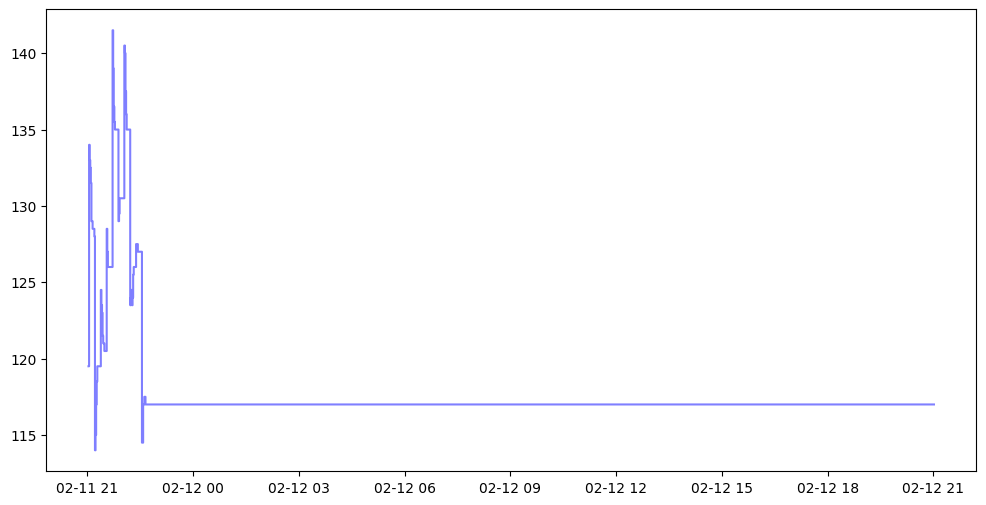

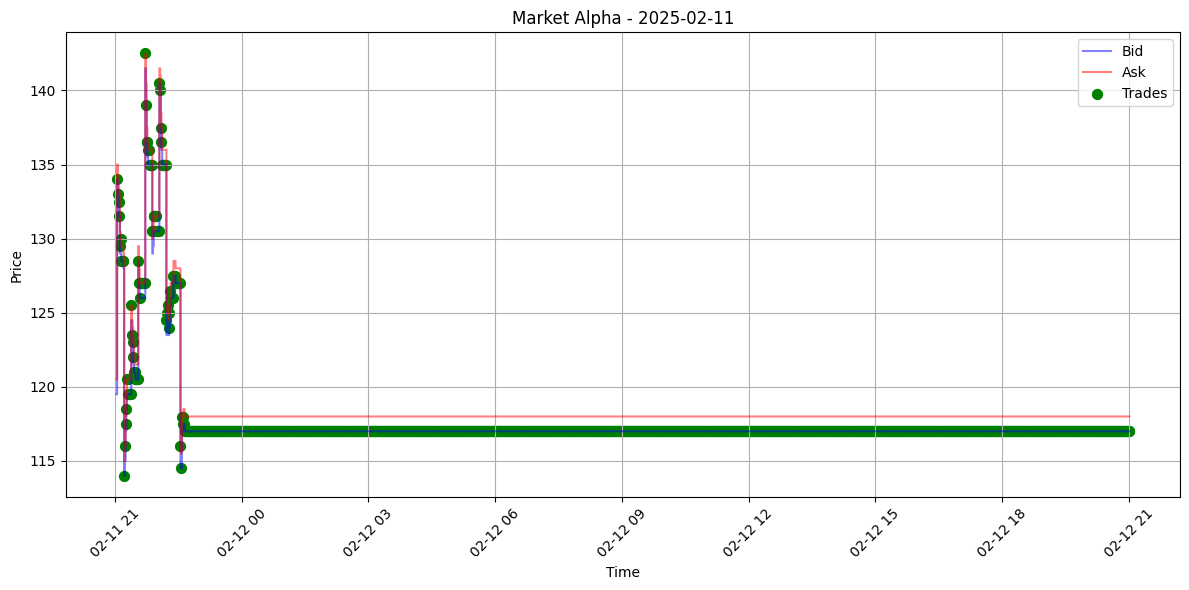

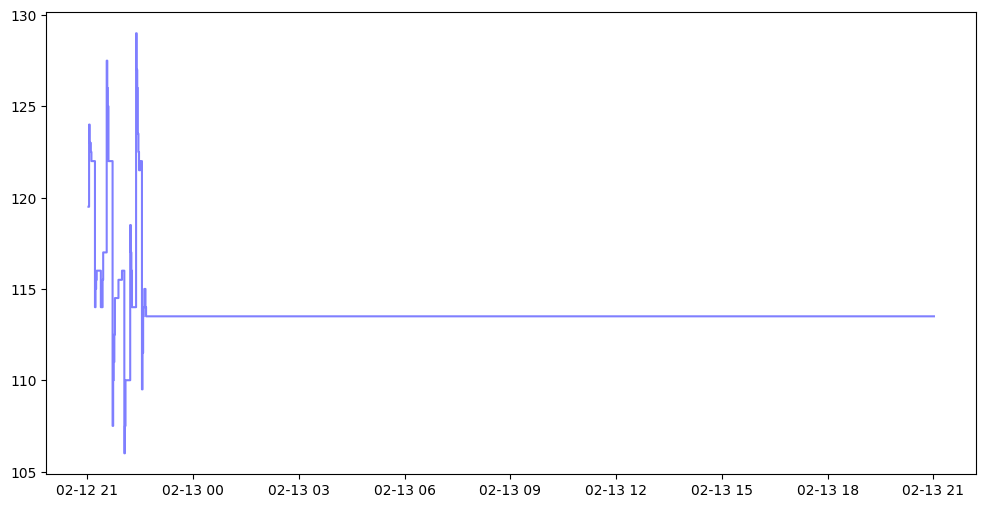

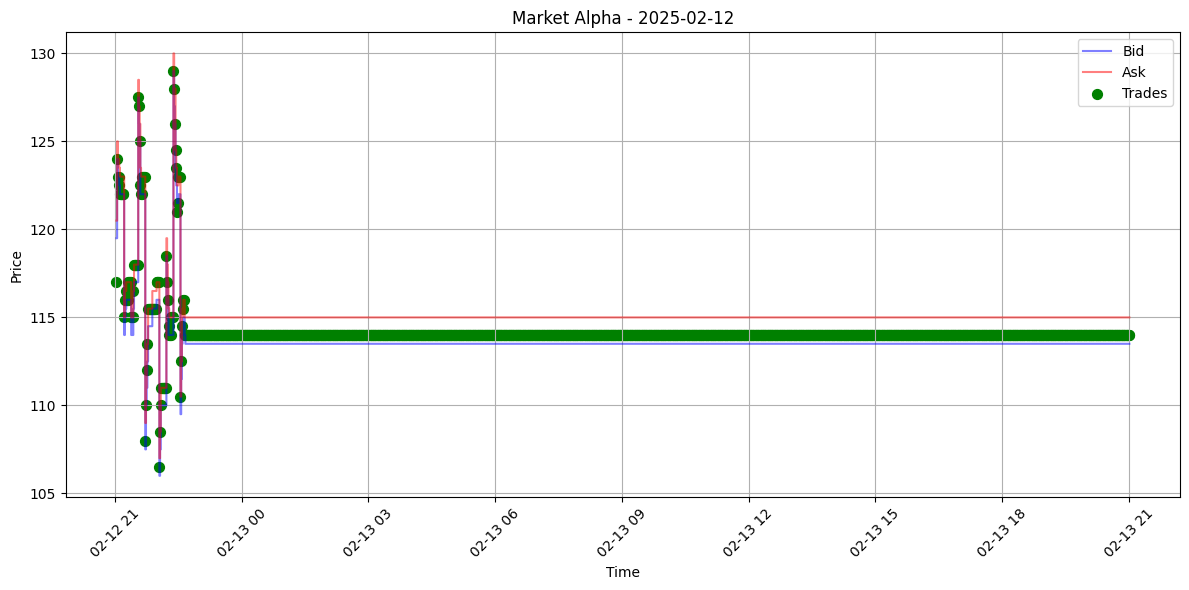

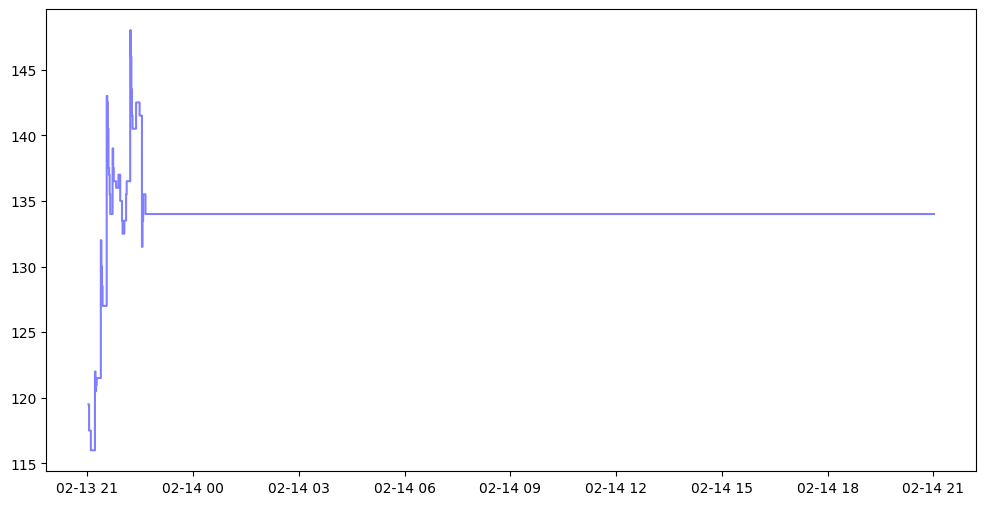

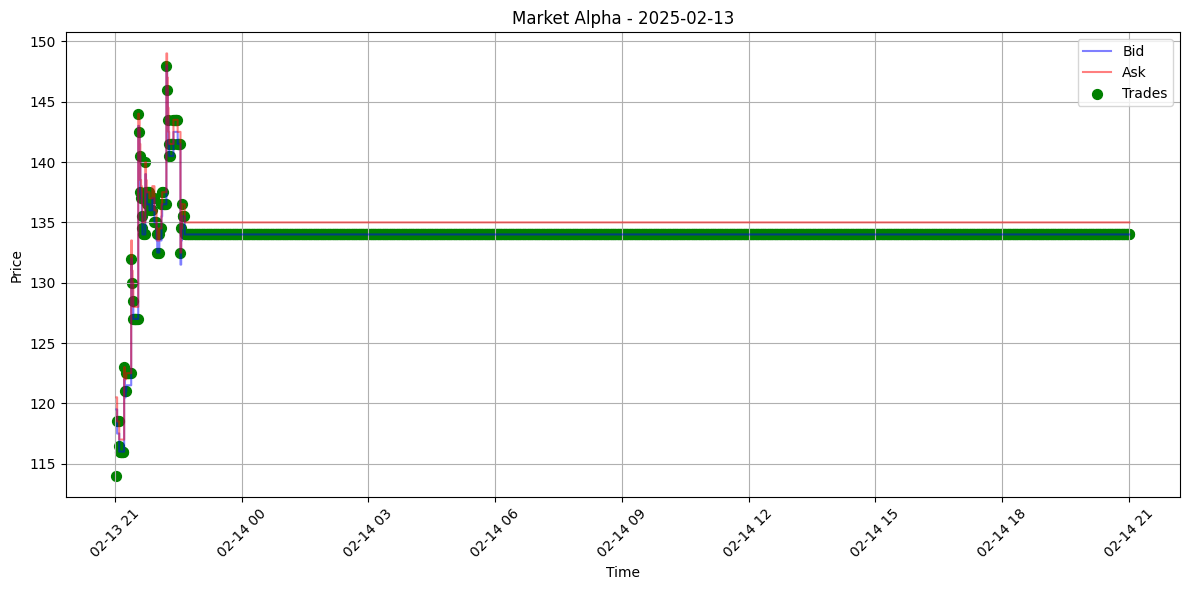

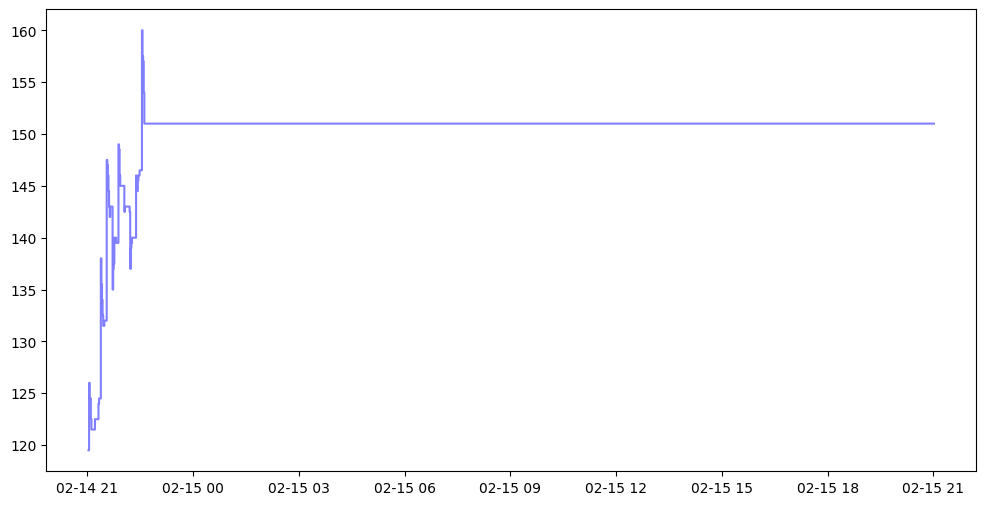

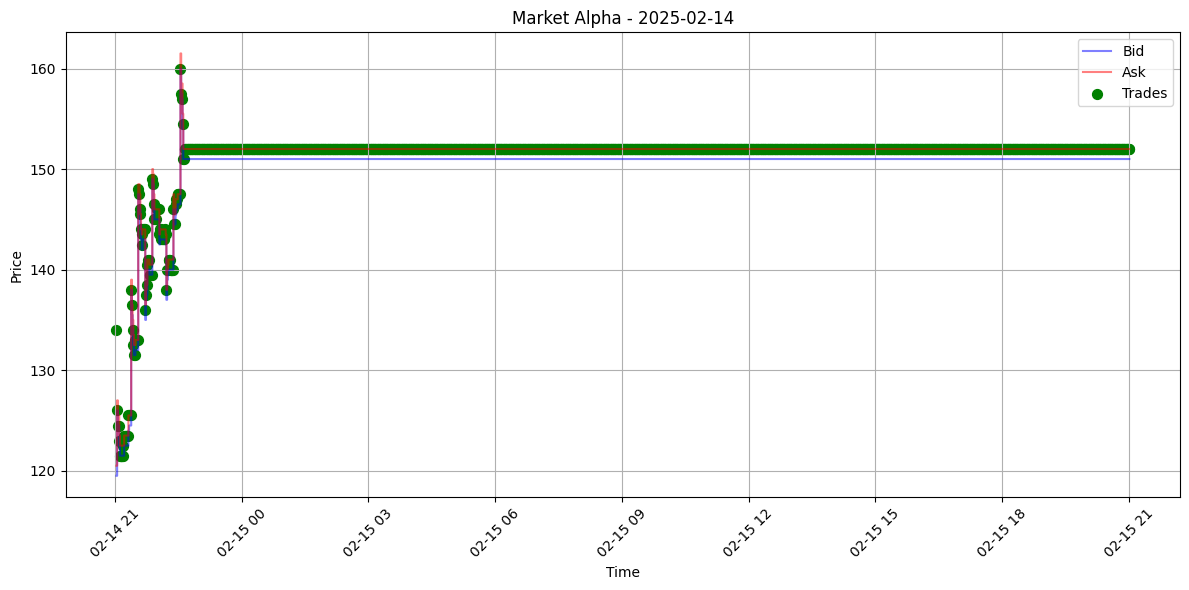

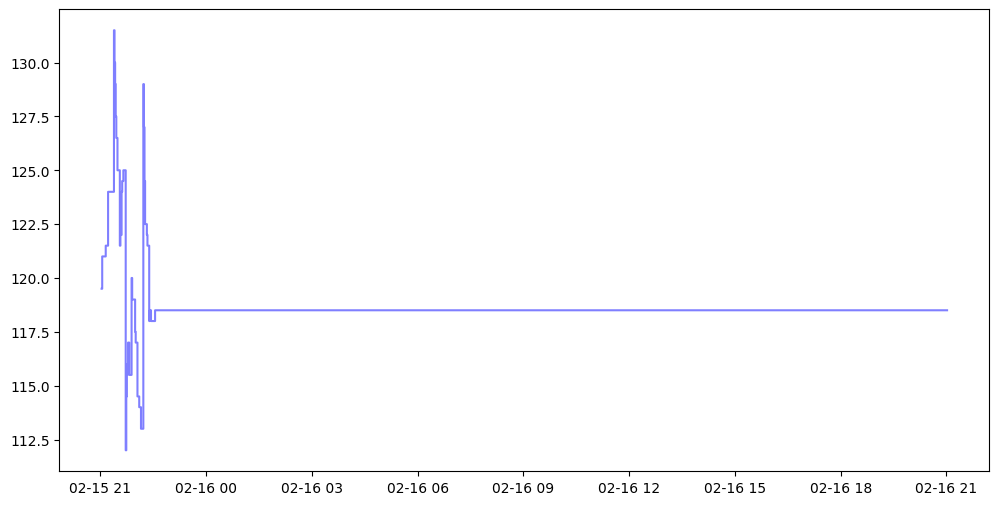

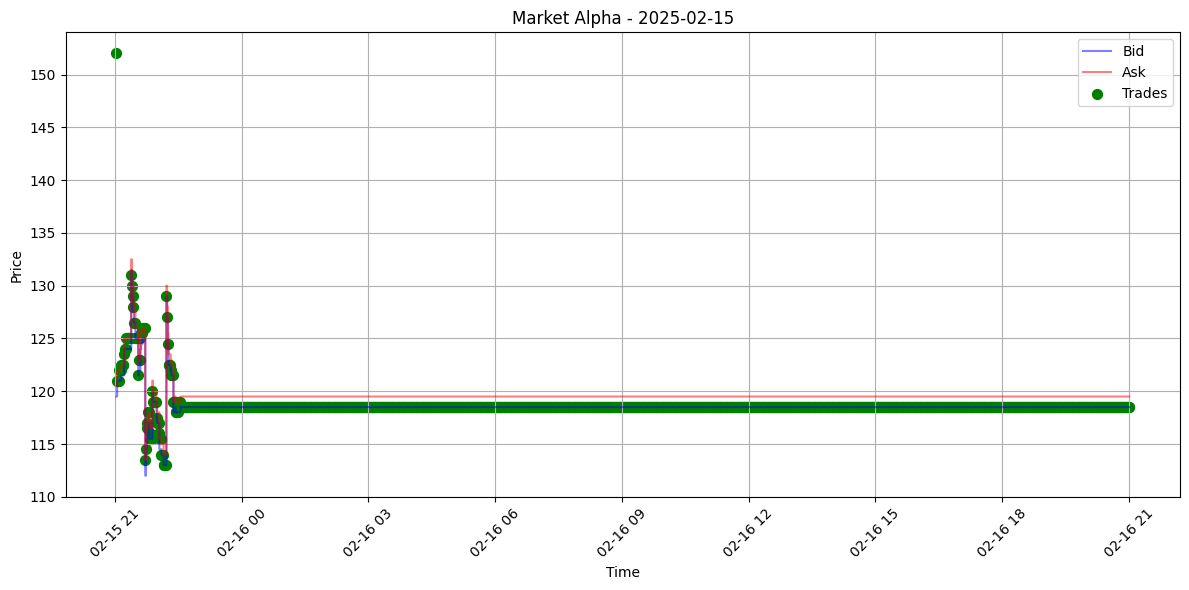

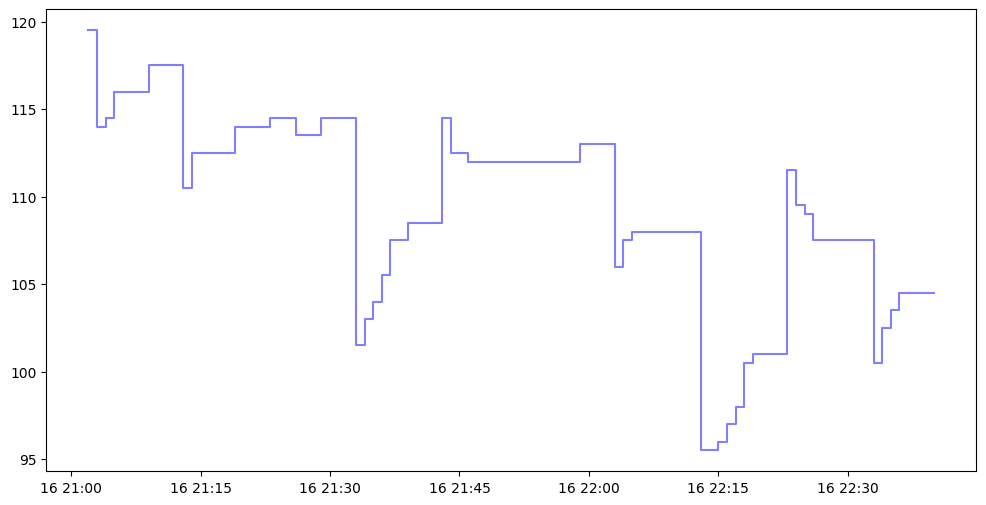

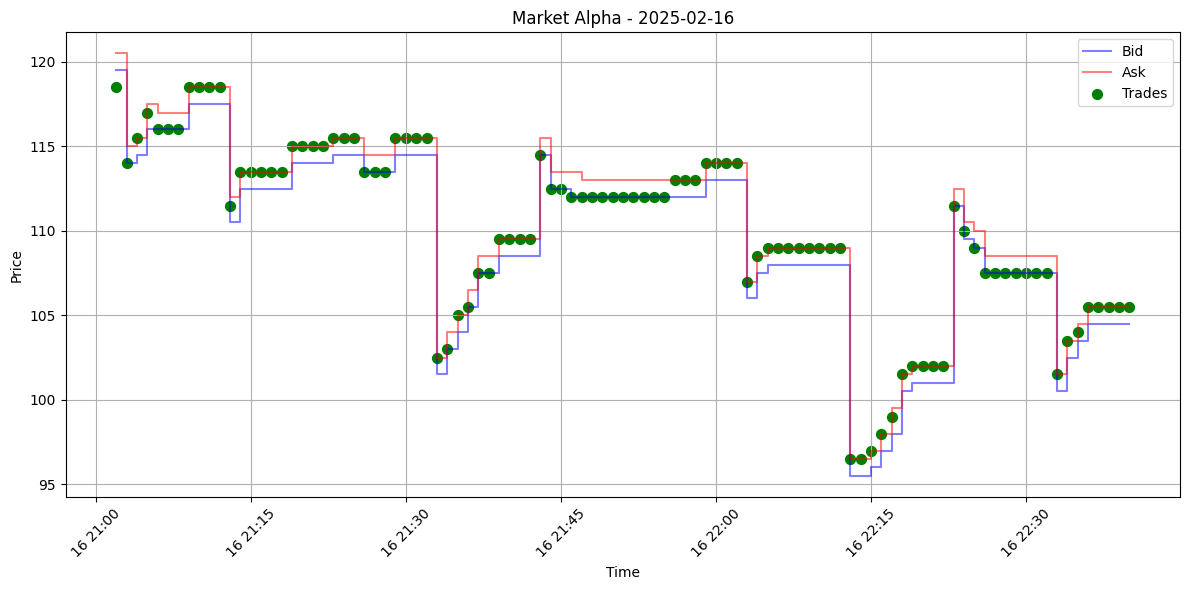

In [ ]:
import matplotlib.pyplot as plt

# Get alpha market data
alpha_data = market_grids['alpha']

# Create a figure for each unique day
for day in alpha_data['days_back'].unique():
    day_data = alpha_data[alpha_data['days_back'] == day]
    
    plt.figure(figsize=(12, 6))
    plt.step(day_data.index, day_data['best_bid_price'], label='Bid', color='blue', alpha=0.5, where='post')
    # Plot bid/ask prices
    plt.figure(figsize=(12, 6))
    
    # Plot bid/ask prices
    plt.step(day_data.index, day_data['best_bid_price'], label='Bid', color='blue', alpha=0.5, where='post')
    plt.step(day_data.index, day_data['best_offer_price'], label='Ask', color='red', alpha=0.5, where='post')
    
    # Plot trades
    trades_mask = day_data['last_trade_price'].notna()
    plt.scatter(day_data[trades_mask].index, 
               day_data[trades_mask]['last_trade_price'],
               label='Trades', color='green', s=50)
    
    plt.title(f'Market Alpha - {day_data.index[0].date()}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
plt.show()